In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Momento de Retroalimentación: Reto Limpieza del Conjunto de Datos

## Predicciones de venta para las tiendas Favorita

Documento de análisis: https://docs.google.com/document/d/1WZNxJ-wSE6K8wZKmX6lFai6Z2BT1WmAgjC3g8u6PCs0/edit

Presentación de avance: https://docs.google.com/presentation/d/1VzJBf_ssgdRzuZ6XmWEBgiDqbYzE2eqXWB2ucQNZnp8/edit#slide=id.g608d0fa1da_0_8133

### Equipo:

**- Fermín Méndez García A01703366**

**- Emiliano Vásquez Olea A01707035**

**- Diego Emilio Barrera  A01366802**

**- Karen Cebreros López A01704254**

### Contenido

1.  Extracción de los datos
2.  Limpieza de los datos
3.  Análisis exploratorio de los datos
4.  Modelos de predicción


# 1. Extracción de los datos

In [ ]:

# Carga de datos en local

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/transactions.csv')
df_oil = pd.read_csv('data/oil.csv')
df_holidays = pd.read_csv('data/holidays_events.csv')

# Carga de datos en kaggle
'''
DATA_PATH = '../input/store-sales-time-series-forecasting'

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))   
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))
df_transactions = pd.read_csv(os.path.join(DATA_PATH, 'transactions.csv'))
df_oil = pd.read_csv(os.path.join(DATA_PATH, 'oil.csv'))
df_holidays = pd.read_csv(os.path.join(DATA_PATH, 'holidays_events.csv'))

'''

In [ ]:
df_stores.describe()

store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000

### 1.1 Asignando los tipos a los dataframes

In [ ]:
# Data types

df_train["date"] = pd.to_datetime(df_train.date)
df_test["date"] = pd.to_datetime(df_test.date)
df_transactions["date"] = pd.to_datetime(df_transactions.date)

df_train.onpromotion = df_train.onpromotion.astype("float16")
df_train.sales = df_train.sales.astype("float32")
df_stores.cluster = df_stores.cluster.astype("int8")


# 2 Limpieza de los datos

### 2.1 Identificar valores faltantes 

In [ ]:
print("Missing values train: ",df_train.isna().sum().sum()) 
print("Missing values test: ",df_test.isna().sum().sum()) 
print("Missing values stores: ",df_stores.isna().sum().sum()) 
print("Missing values transictions: ",df_transactions.isna().sum().sum()) 
print("Missing values oil: ",df_oil.isna().sum().sum())
print("Missing values holidays: ",df_holidays.isna().sum().sum()) 

Missing values train:  0
Missing values test:  0
Missing values stores:  0
Missing values transictions:  0
Missing values oil:  43
Missing values holidays:  0


El único dataset incompleto es el de oil. Vamos a evaluar si se pueden imputar.

In [ ]:
print(df_oil.isna().sum())
print(df_oil.describe())
print(df_oil.columns)

date           0
dcoilwtico    43
dtype: int64
        dcoilwtico
count  1175.000000
mean     67.714366
std      25.630476
min      26.190000
25%      46.405000
50%      53.190000
75%      95.660000
max     110.620000
Index(['date', 'dcoilwtico'], dtype='object')


<Axes: xlabel='date', ylabel='dcoilwtico'>

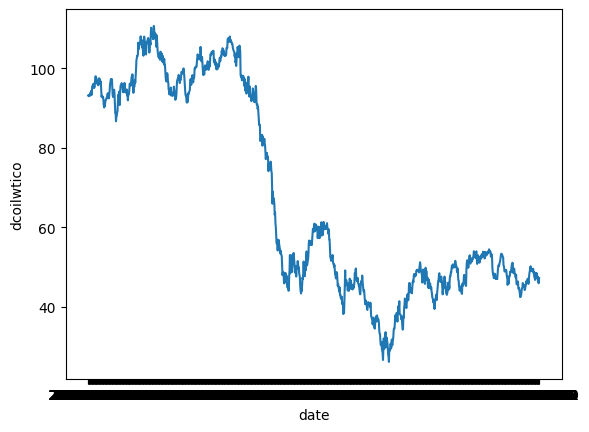

In [ ]:
sns.lineplot(x='date', y='dcoilwtico', data=df_oil)


In [ ]:
# Llenar datos faltantes del precio del petróleo con el valor del dia posterior
df_oil.fillna(method='bfill', inplace = True)

Dado que hay 1,218 registros y vamos a imputar 43 representan apenas el 3% de los datos lo que no afectaría en gran medida. Además para sustituir los valores faltantes tomaremos el valor del día siguiente. Como se puede ver en la gráfica el valor del petroleo es más o menos continuo, tomar el valor del ida siguiente no es mala aproximación.

In [ ]:
df_oil.isna().sum()
#Comprobamos que tenemos todos los datos

date          0
dcoilwtico    0
dtype: int64

## 2.2 Explorando el dataSet principal df_train

In [ ]:
a = df_train.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

Con esta gráfica tenemos un panorama general de las ventas de cada tienda a lo largo de todo el periodo. Podemos identificar algunos valores ceros y otros extremos. A continuación daremos más detalle.

### 2.2.1 Eliminando los valores ceros

En este caso eliminamos registros sin ventas de ciertas tiendas, indicando posiblemente una falta de información o que las sucursales no habían sido abiertas.
Los valores de ventas 0 por largos periodos no nos aportan información.

In [ ]:
df_train = df_train[~((df_train.store_nbr == 52) & (df_train.date < '2017-04-20'))]
df_train = df_train[~((df_train.store_nbr == 22) & (df_train.date < '2015-10-09'))]
df_train = df_train[~((df_train.store_nbr == 42) & (df_train.date < '2015-08-21'))]
df_train = df_train[~((df_train.store_nbr == 21) & (df_train.date < '2015-07-24'))]
df_train = df_train[~((df_train.store_nbr == 29) & (df_train.date < '2015-03-20'))]
df_train = df_train[~((df_train.store_nbr == 20) & (df_train.date < '2015-02-13'))]
df_train = df_train[~((df_train.store_nbr == 53) & (df_train.date < '2014-05-29'))]
df_train = df_train[~((df_train.store_nbr == 36) & (df_train.date < '2013-05-09'))]
df_train = df_train[~((df_train.store_nbr == 12) & (df_train.date < '2015-05-29'))]

### 2.2.2 Identificar valores atípicos

En la gráfica de la sección 2.2, ventas por sucursal, podemos observar las ventas de cada tienda a lo largo de los 4 años que tenemos disponibles. Resaltan algunos valores máximos atípicos.
Vemos que en el mes Abril y Mayo del 2016 tenemos algunos picos extremos. Teniendo en cuenta que el 16 de Abril del 2016 el tuvo evento un terremoto de magnitud 7.8, vamos considerar estos picos como valores impredecibles y consecuencia del terremoto. Por eso tomamos la decisión de aplanarlos, buscaremos valores dentro de los rangos normales.
Para eso vamos a hacer un zoom a ese periodo y esas tiendas.

Antes de pasar al periodo Abril-Mayo del 2016 haremos la misma gráfica en el año 2015 para tener una referencia del comportamiento en esos meses. La tienda número 44 se mantuvo como una de las mejores y la 32 como una de las ventas más bajas. Estas tiendas pueden servir como margen superior e inferior para eliminar los valores extremos de abril y mayo del 2016.

La gráfica va del primero de Abril al primero de Junio,


In [ ]:
df=df_train.copy()

df=df[(df['date'] >= '2015-04-01') & (df['date'] <= '2015-06-01')]
a = df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

Ahora sí. Obervemos la gráfica de ventas por tienda Abril- Mayo 2016

In [ ]:
df=df_train.copy()

df=df[(df['date'] >= '2016-04-01') & (df['date'] <= '2016-06-01')]
a = df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

Tenemos entonces las tiendas que sufrieron anomalias: 2, 20, 44, 45 ,53 recordemos que usaremos la tienda 32 como limite inferior y la 44 como superior. Filtremos solo estas tiendas.

In [ ]:
df=df_train.copy()
stores=s+[2,20,45,53, 44,32]
#stores=range(100)
df=df[(df['date'] >= '2015-04-01') & (df['date'] <= '2015-06-01') & (df['store_nbr'].isin(stores) )]
a = df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")

Hagamos una lista de las tiendas y las fechas en las que reportan extremos por encima de la tienda 44 o debajo de la 32.

- 18 Abril, tienda 45, pico de ventas
- 21 Abril, tienda 20, pico de ventas
- 21 Abril, tienda 45, pico de ventas
- 21 Abril, tienda 2, pico de ventas
- 26 Abril, tienda 2, pico de ventas
- 26 Abril, tienda 2, pico de ventas
- 02 Mayo, tienda 2, pico de ventas
- 12 Mayo, tienda 20, pico de ventas


- 17 Abril, tienda 53, muy pocas ventas
- 18 Abril, tienda 53, muy pocas ventas

Ya tenemos las fechas y tiendas exactas que representan anomalía. Con base en la gráfica de 2015 seleccionamos tiendas análogas a cada una de las tiendas afectadas. Es decir, los valores atípicos de las tiendas serán sustituidos por los mismos valores de ese día de una tienda con ventas similares el año anterior. La lista sustitución queda de la siguiente manera:
Una vez identificamos que tiendas y que fechas presentan anomalias vamos a seleccionar una tienda con un comportamiento similar en el año pasado y vamos a sobreescribir el valor de las fechas anormales con su tienda analoga.
- Tienda 2 que fue afectada se sustituirá por el valor de la tienda 4
- Tienda 20 que fue afectada se sustituirá por el valor de la tienda 27
- Tienda 45 que fue afectada se sustituirá por el valor de la tienda 47
- Tienda 53 que fue afectada se sustituirá por el valor de la tienda 54

AQUI LA SUSTITUCIÓN QUE AUN NO JALA. VEMOS QUE LOS VALORES SUSTITUIDOS SE CAEN A NaN's

In [ ]:
#Algo así pero arroja nands
df=df_train.copy()

df.loc[(df['date'] == '2016-04-18') & (df['store_nbr'] == 45), 'sales'] = df.loc[(df['date'] == '2016-04-18') & (df['store_nbr'] == 47), 'sales']

df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 20), 'sales'] = df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 27), 'sales']
df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 45), 'sales'] = df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 47), 'sales']
df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 2), 'sales'] = df.loc[(df['date'] == '2016-04-21') & (df['store_nbr'] == 4), 'sales']

df.loc[(df['date'] == '2016-04-26') & (df['store_nbr'] == 2), 'sales'] = df.loc[(df['date'] == '2016-04-26') & (df['store_nbr'] == 4), 'sales']
df.loc[(df['date'] == '2016-05-02') & (df['store_nbr'] == 2), 'sales'] = df.loc[(df['date'] == '2016-05-02') & (df['store_nbr'] == 4), 'sales']
df.loc[(df['date'] == '2016-05-12') & (df['store_nbr'] == 20), 'sales'] = df.loc[(df['date'] == '2016-05-12') & (df['store_nbr'] == 27), 'sales']

df.loc[(df['date'] == '2016-04-17') & (df['store_nbr'] == 53), 'sales'] = df.loc[(df['date'] == '2016-04-17') & (df['store_nbr'] == 54), 'sales']
df.loc[(df['date'] == '2016-04-18') & (df['store_nbr'] == 53), 'sales'] = df.loc[(df['date'] == '2016-04-18') & (df['store_nbr'] == 54), 'sales']

Comprobamos que ya no hay picos

In [ ]:
stores=[2,20,44,45,53,32]
df=df[(df['date'] >= '2016-04-01') & (df['date'] <= '2016-06-01') & (df['store_nbr'].isin(stores) )]
a = df.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores")


### 2.2.3 Eliminando identificadores únicos

In [ ]:
df_train.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1 2013-01-01          1   BABY CARE    0.0          0.0
2 2013-01-01          1      BEAUTY    0.0          0.0
3 2013-01-01          1   BEVERAGES    0.0          0.0
4 2013-01-01          1       BOOKS    0.0          0.0

Eliminamos la columna de id del dataset de entrenamiento, ya que es un identificador único y no aporta al modelo predictivo.

In [ ]:
df_train.drop(['id'], axis = 1, inplace = True)

# 3 Análisis exploratorio de los datos

## 3.1 Análisis de train

### 3.1.1 Estadistica descriptiva

In [ ]:
df_train.head()

date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1 2013-01-01          1   BABY CARE    0.0          0.0
2 2013-01-01          1      BEAUTY    0.0          0.0
3 2013-01-01          1   BEVERAGES    0.0          0.0
4 2013-01-01          1       BOOKS    0.0          0.0

### 3.1.2 Hot encoding para variables categóricas

Aplicamos One Hot Encoding sobre los datos de entrenamiento para representar los valores categóricos de la columna "family" de forma numérica.

In [ ]:
encoded_family_df = pd.get_dummies(df_train['family'], prefix='family')
df_train_encoded = pd.concat([df_train, encoded_family_df], axis = 1).drop(['family'], axis = 1)

In [ ]:
df_train_encoded

date  store_nbr        sales  onpromotion  family_AUTOMOTIVE  \
0       2013-01-01          1     0.000000          0.0               True   
1       2013-01-01          1     0.000000          0.0              False   
2       2013-01-01          1     0.000000          0.0              False   
3       2013-01-01          1     0.000000          0.0              False   
4       2013-01-01          1     0.000000          0.0              False   
...            ...        ...          ...          ...                ...   
3000883 2017-08-15          9   438.132996          0.0              False   
3000884 2017-08-15          9   154.552994          1.0              False   
3000885 2017-08-15          9  2419.729004        148.0              False   
3000886 2017-08-15          9   121.000000          8.0              False   
3000887 2017-08-15          9    16.000000          0.0              False   

         family_BABY CARE  family_BEAUTY  family_BEVERAGES  family_BOOKS  \
0                   False          False             False         False   
1                    True          False             False         False   
2                   False           True             False         False   
3                   False          False              True         False   
4                   False          False             False          True   
...                   ...            ...               ...           ...   
3000883             False          False             False         False   
3000884             False          False             False         False   
3000885             False          False             False         False   
3000886             False          False             False         False   
3000887             False          False             False         False   

         family_BREAD/BAKERY  ...  family_MAGAZINES  family_MEATS  \
0                      False  ...             False         False   
1                      False  ...             False         False   
2                      False  ...             False         False   
3                      False  ...             False         False   
4                      False  ...             False         False   
...                      ...  ...               ...           ...   
3000883                False  ...             False         False   
3000884                False  ...             False         False   
3000885                False  ...             False         False   
3000886                False  ...             False         False   
3000887                False  ...             False         False   

         family_PERSONAL CARE  family_PET SUPPLIES  \
0                       False                False   
1                       False                False   
2                       False                False   
3                       False                False   
4                       False                False   
...                       ...                  ...   
3000883                 False                False   
3000884                 False                False   
3000885                 False                False   
3000886                 False                False   
3000887                 False                False   

         family_PLAYERS AND ELECTRONICS  family_POULTRY  \
0                                 False           False   
1                                 False           False   
2                                 False           False   
3                                 False           False   
4                                 False           False   
...                                 ...             ...   
3000883                           False            True   
3000884                           False           False   
3000885                           False           False   
3000886                           False           False   
3000887                           Fal

La aplicación del one hot encoding fué un método usado inicialmente para intentar representar todos nuestros atributos de forma numérica para que fueran utilizables dentro de una regresión lineal.
Mientras que la regresión lineal si es utilizada como propuesta de solución, la aplicación de este one hot encoding no fué necesaria debido al uso de "unstack" para reorganizar los datos.

### 3.1.3 Matriz de correlación

Graficamos la correlación entre las variables originales.

In [ ]:
correlation_matrix = df_train.corr()

# Set up the heatmap figure
plt.figure(figsize = (10, 8))

# Create heatmap using seaborn
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", center = 0)

# Show the plot
plt.title("Correlación entre atributos de train.csv")
plt.show()

ValueError: could not convert string to float: 'AUTOMOTIVE'

En la gráfica anterior podemos ver como se correlacionan las variables entre las variables del dataset. 
Esta gráfica nos sirve meramente para visualizar como es que pueden variar los valores de una variable (valga la redundancia), dependiendo a los valores de otra. Por ejemplo, podemos ver que hay una correlación casi de .5 entre sales y onpromotion; lo cual hace sentido por la naturaleza y el objetivo de la variable onpromotion.

## 3.1.4 Panorama de promedio de ventas

Sacamos el promedio de ventas por todas las tiendas en un día.

In [ ]:
average_sales = df_train.groupby('date')['sales'].mean()
average_sales_df = average_sales.reset_index()

Gráfico de datos y marcar tendencia a lo largo de los años

In [ ]:
px.scatter(x = pd.to_datetime(average_sales_df["date"]), y = average_sales_df["sales"], trendline="ols", trendline_color_override = 'red')

Es posible que algunos de los valores extremos se deban a situaciones especiales, como el terremoto de gran magnitud del 2016 en Ecuador.

In [ ]:
average_sales_by_family = df_train.groupby('family')['sales'].mean()

### 3.2 Análisis del precio del petróleo

El petróleo es un factor que refleja la economía de Ecuador, al ser un país petrolero. Este es uno de los indicadores externos que puede afectar las ventas de las tiendas Favorita, por lo que es importante tomarlo en cuenta.

In [ ]:
df_oil.describe()

dcoilwtico
count  1218.000000
mean     67.673325
std      25.637345
min      26.190000
25%      46.422500
50%      53.185000
75%      95.595000
max     110.620000

En estos datos vemos un valor mínimo de 26 y un máximo de 110, mostrando una gran variabilidad entre años. Este máximo es más de cuatro veces el valor mínimo.

<Axes: xlabel='date', ylabel='dcoilwtico'>

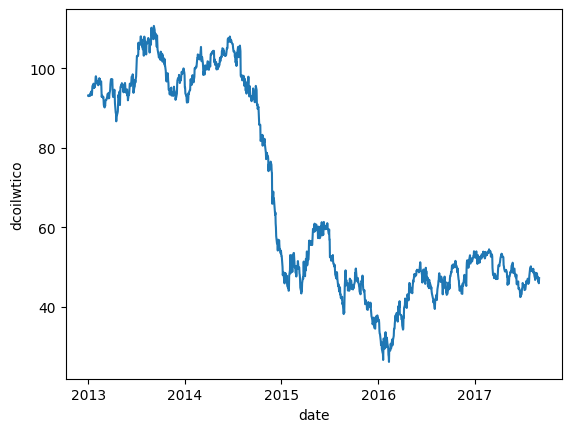

In [ ]:
sns.lineplot(df_oil, x = pd.to_datetime(df_oil["date"]), y = df_oil["dcoilwtico"])

En la gráfica anterior podemos observar como es que el valor del petróleo fue variando desde el 2013 hasta el 2018 aproximadamente.

Analizando un poco lo que aparece en la gráfica, podemos ver que antes del 2015, el valor de éste era por lo menos el doble de lo que era en el resto de los años.

De igual forma, podemos ver que hay un punto en el tiempo (2016) en donde éste llegó a su valor mínimo, que fue una cuarta parte del valor máxiámo que había alcanzado. Después de un breve periodo de tiempo, vuelve a subir casi hasta su valor promedio.

### 3.3 Análisis de transacciones

In [ ]:
df_transactions

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

Promedio de transacciones en un día

In [ ]:
average_transactions = df_transactions.groupby('date')['transactions'].mean()
average_transactions_df = average_transactions.reset_index()

In [ ]:
px.scatter(x = pd.to_datetime(average_transactions_df["date"]), y = average_transactions_df["transactions"], trendline="ols", trendline_color_override = 'red')

En el gráfico anterior podemos observar todas las transacciones a lo largo de los años. Se puede ver que al final de cada año, hay una tendencia a que se eleve la cantidad de transacciones a casi el doble de las que hay normalmente. Intuímos que esto pasa debido a la temporada y las eventualidades a finales de cada año.

### 3.4  Análisis de relación entre Oil y Transactions

In [ ]:
average_price = df_oil.groupby('date')['dcoilwtico'].mean()
average_price.head()

date
2013-01-01    93.14
2013-01-02    93.14
2013-01-03    92.97
2013-01-04    93.12
2013-01-07    93.20
Name: dcoilwtico, dtype: float64

<Axes: title={'center': 'Average of Oil Price'}, xlabel='date'>

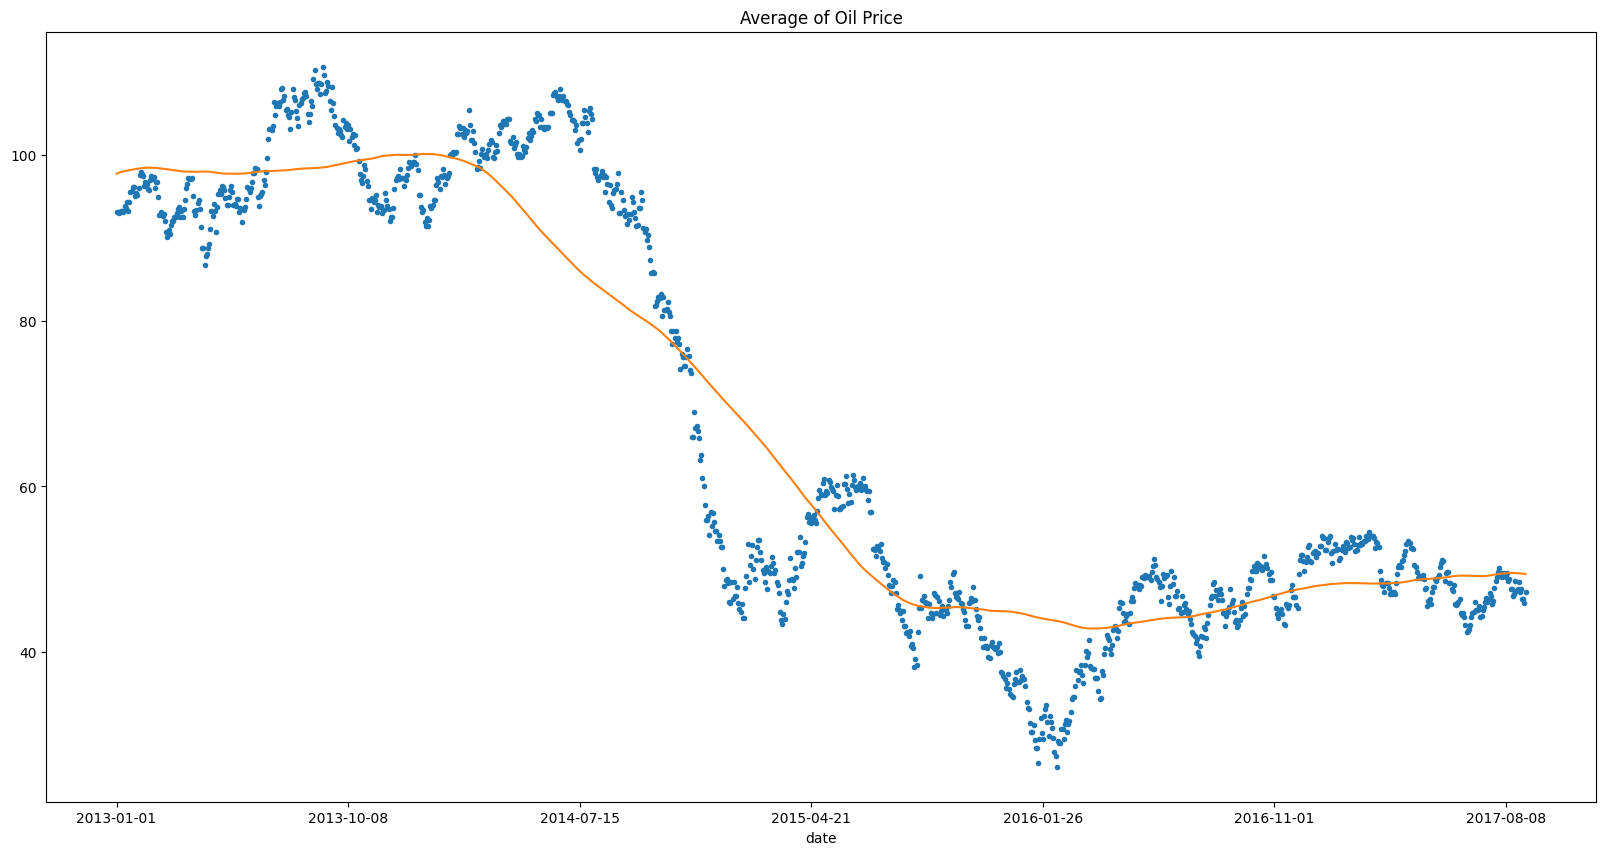

In [ ]:
moving_average3 = average_price.rolling(window=365, center=True, min_periods=183).mean()
average_price.plot(style='.',figsize=(20,10), title='Average of Oil Price')
moving_average3.plot()

<Axes: title={'center': 'Average of Transaction'}, xlabel='date'>

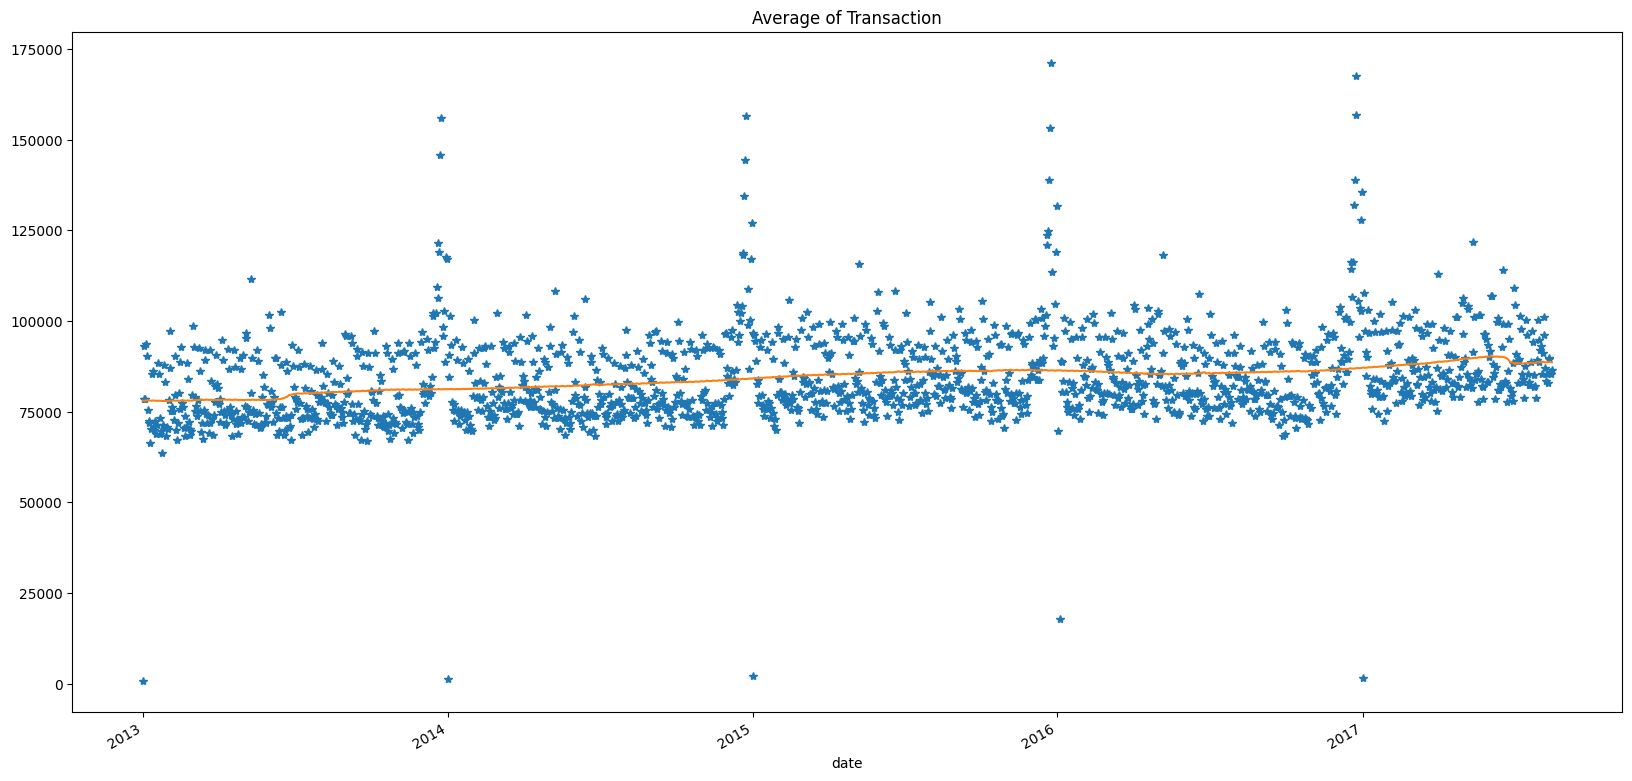

In [ ]:
sum_transaction = df_transactions.groupby('date').sum()['transactions']
sum_transaction = sum_transaction.copy()
moving_sum_transaction = sum_transaction.rolling(window=365, center=True, min_periods=183).mean()
sum_transaction.plot(style='*', figsize=(20, 10), title='Average of Transaction')
moving_sum_transaction.plot()

### ¿Qué observamos?
Comprobamos si existe alguna relación entre el precio del petróleo y la transacción.
Obtenemos el gráfico del precio del petróleo frente al tiempo del precio del petróleo.
y luego tenemos el gráfico de Transacción contra el tiempo.


Notamos que para el gráfico del precio del petróleo, está bajando en 4 años,
y para el gráfico de transacciones, es casi estable en 4 años.
Se confirma que es posible que no tengan una relación lineal.

### 3.5 Análisis de relación entre Sales y Transactions

<Axes: title={'center': 'Average of Sales'}, xlabel='date'>

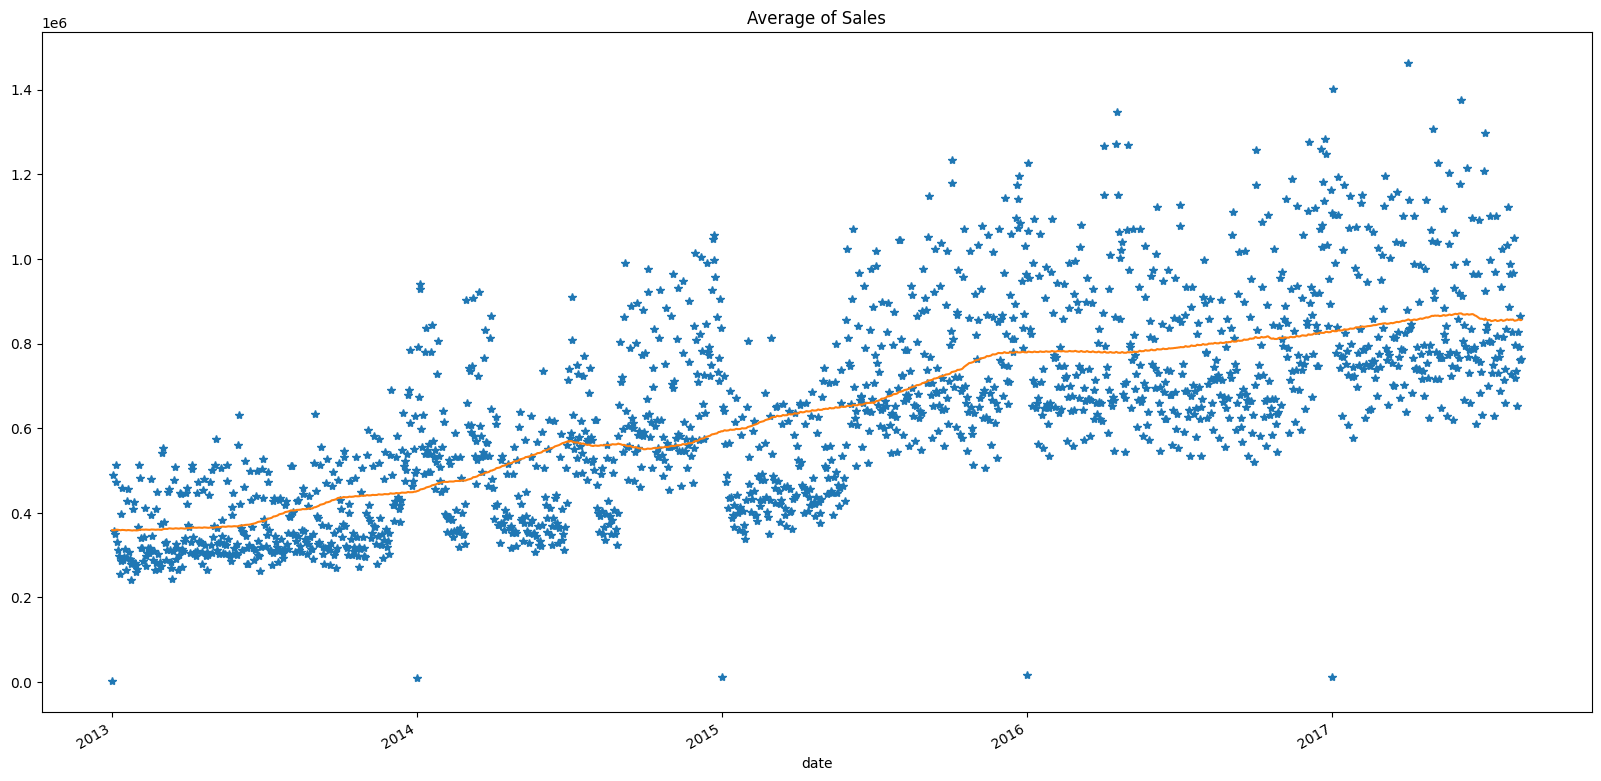

In [ ]:
sum_sales = df_train.groupby('date').sum()['sales']
sum_sales = sum_sales.copy()
moving_sum_sales = sum_sales.rolling(window=365, center=True, min_periods=183).mean()
sum_sales.plot(style='*', figsize=(20, 10), title='Average of Sales')
moving_sum_sales.plot()

Podemos observar que las ventas si están creciendo conforme pasa el tiempo, pero no de una forma lineal, sino que hay ciertos periodos en los que crece más que en otros, a diferencia de las transacciones, que se mantienen casi constantes.

<Axes: title={'center': 'Transaction Vs Sales'}, xlabel='transactions', ylabel='sales'>

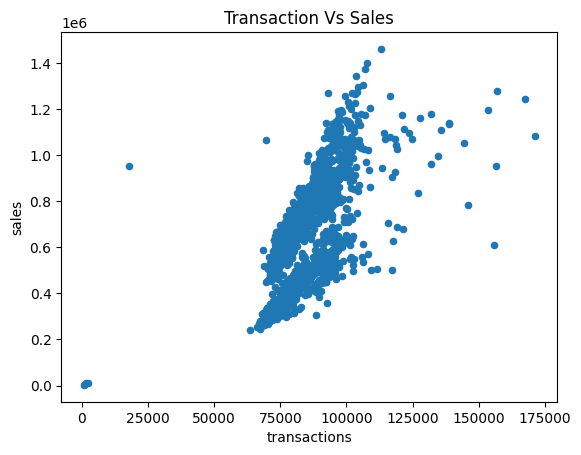

In [ ]:
date_transaction_sales = pd.merge(sum_transaction, sum_sales, on='date')
date_transaction_sales.plot.scatter(x='transactions', y='sales', title='Transaction Vs Sales')

### ¿Qué observamos?
Podemos observar que hay una clara relación entre las ventas y las transacciones, ya que conforme aumentan las transacciones, también aumentan las ventas.

### 3.6 Análisis por estaciones

In [ ]:
#from learntools.time_series.utils import plot_periodogram, seasonal_plot

Identificar los periodos de tiempo donde existen patrones fuertes en el comportamiento.

In [ ]:
#plot_periodogram(average_sales);

In [ ]:
"""
store_sales = pd.read_csv(
    os.path.join(DATA_PATH, 'train.csv'),
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
"""

"\nstore_sales = pd.read_csv(\n    os.path.join(DATA_PATH, 'train.csv'),\n    usecols=['store_nbr', 'family', 'date', 'sales'],\n    dtype={\n        'store_nbr': 'category',\n        'family': 'category',\n        'sales': 'float32',\n    },\n    parse_dates=['date'],\n    infer_datetime_format=True,\n)\nstore_sales['date'] = store_sales.date.dt.to_period('D')\nstore_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()\naverage_sales = (\n    store_sales\n    .groupby('date').mean()\n    .squeeze()\n    .loc['2017']\n)\n"

Promedio de ventas por dia en cada tienda en el año 2017

In [ ]:
'''
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');
'''

'\nX = average_sales.to_frame()\nX["week"] = X.index.week\nX["day"] = X.index.dayofweek\nseasonal_plot(X, y=\'sales\', period=\'week\', freq=\'day\');\n'

## Transformación de datos para entrenamiento

Para entrenar nuestro modelo de regresión lineal queremos extraer datos sobre la estacionalidad en nuestro dataset. Como vimos en graficos anteriores, se sigue un patrón a lo largo del año desde varianza en las ventas en diferentes días de la semana, hasta aquellos cambios producidos por dias festivos.

Para poder respresentar este comportamiento en nuestro modelo es necesario que transformemos nuestros datos de entrenamiento, que nos indican fechas, el producto, número de la tienda y ventas, en componentes de Fourier.

Primero reasignamos nuestro índice y el tipo de dato de la fecha, ya que estos deben ser compatibles con la función de DeterministicProcess que se usará más adelante.

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['date'] = df_train.date.dt.to_period('D')

df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

Aplicando la función unstack reorganizamos nuestros datos de entrenamiento. De esta forma cada fila de nuestro dataset solo representará una fecha, pero se agregan columnas para representar toda la información sobre las ventas por tipo de producto y número de tienda.

In [ ]:
df_train_unstacked = df_train.unstack(['store_nbr','family'])

In [ ]:
df_train_unstacked

La función DeterministicProcess se encarga de generar diferentes términos determinísticos sobre nuestros datos de entrada, que son los nuevos "features" que describen el comportamiento de los datos a lo largo del tiempo. Estos son los datos que podemos utilizar para entrenar nuestro modelo de aprendizaje automático y posteriormente realizar nuestras predicciones.

In [ ]:
fourier_terms = CalendarFourier(freq='Y', order=4)

dp = DeterministicProcess(
    index = df_train_unstacked.index,
    constant = True,
    order = 0,
    seasonal = True,
    additional_terms = [fourier_terms],
    drop = True,
)

df_x_train = dp.in_sample()
df_x_train

### Días festivos

Ya que tenemos nuestros "features" para cada día que compone el dataset, debemos agregar otros atributos importantes para nuestro análisis, que puede incluir la información que vemos en los demás datasets del reto.

Por ejemplo, los días festivos. Del archivo holidays.csv podemos obtener información que describa cierto comportamiento en días específicos del año, por ejemplo, la falta de ventas a inicios de año, o una mayor demanda en preparación a fiestas nacionales. Estos datos nos permiten agregar características a nuestro modelo para incluir estos comportamientos que no siempre son descritos por la información más general de estacionalidad.

In [ ]:
df_holidays

Aplicamos One Hot Encoding sobre los datos de df_holidays para representar sus valores categóricos de forma numérica.

In [ ]:
df_holidays_encoded = pd.get_dummies(df_holidays['description'], prefix='holiday')

# Al ejecutar la función get_dummies perdemos la columna de fechas, la cual requerimos para realizar el join mas adelante con nuestros features iniciales
df_holidays_encoded = pd.concat([df_holidays_encoded, df_holidays['date']], axis = 1) # Volvemos a agregar la columna de fechas
df_holidays_encoded['date'] = pd.to_datetime(df_holidays_encoded['date']).dt.to_period('D') # Cambiamos pormato de fecha a Period para que sea igual al índice de los features

df_holidays_encoded = df_holidays_encoded.set_index('date')

Después de haber aplicado este proceso, podemos ver que, como algunas celebraciones ocurren en un mismo día, se duplican los registros para algunas fechas. Por ejemplo, el 14 de Abril se celebra un Viernes Santo, así como la Cantonizacion de Libertad.

In [ ]:
df_holidays_encoded.loc[['2017-04-14']]

Es por ello que debemos aplicar otra transformación sobre estos datos para agrupar una fecha en una misma fila.

In [ ]:
df_holidays_encoded = df_holidays_encoded.groupby(df_holidays_encoded.index).sum()

De esta forma hemos transformado nuestro dataframe con los dias festivos para indicar, para cada una de las fechas registradas, si hay o no un evento festivo en específico.

Esto nos permite utilizar estos atributos dentro de nuestro modelo de regresión lineal.

In [ ]:
df_holidays_encoded

Ya que tenemos nuestros datos de días festivos codificados, vamos a unirlos a nuestros features originales (Los obtenidos a partir del Deterministic Process)

In [ ]:
df_x_train = df_x_train.join(df_holidays_encoded).fillna(0) # Llenamos los valores faltantes con 0, indicando que no sucede el día festivo

In [ ]:
df_x_train

# 4 Propuesta de solución

In [ ]:
y = df_train_unstacked.fillna(0)

model = LinearRegression(fit_intercept = True)
model.fit(df_x_train, y)

In [ ]:
y_pred = pd.DataFrame(model.predict(df_x_train), index=df_x_train.index, columns=y.columns)

In [ ]:
y

In [ ]:
y_pred